<a href="https://colab.research.google.com/github/ArpanSM/Machine_Learning_Hackathons/blob/master/CRYPTO_Training_and_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

##Notebook Outline

---
---

###Library Loading

---
###Data Retrival

* Downloading NASDAQ listed comapanies data and filtering them according to the need. 
* Downloading historical stock data from 1990 of top 150 NASDAQ US companies.


---
###Feature engineering and Data preprocessing

* Adding various Technical Indicators such as MACD.
* Adding the prediction values, percentage change and target direction.
* Feature Selection to minimize overfitting.


---
###Clustering

* Clustering the 100 companies into similar groups based on selected features.
* Elbow graph usage for number of cluster.



---

###Data Spliting

* Splitting data into various time series.



---
###Machine Learning Classification Modelling

* Building ML models of all the clusters separately.
* Performing hyperparameter tuning on those models.
* Analyzing confusion metrics and precision scores.

---

###Validation Testing

* Predicting the target probability and sorting them on decreasing order.
* Analyzing the model prediction using  SHAP.
* Explaining model interpretability using SHAP
---





#Machine learning modelling

###Libraries

In [ ]:
!pip install shap
!pip install pycaret[full]

     |████████████████████████████████| 358kB 4.2MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491629 sha256=cb3f2bf80d308279b2d90690dea8ed0dc03f26e851d54775950cd33d38da0a7d
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 266kB 5.9MB/s 
     |████████████████████████████████| 215kB 39.5MB/s 
     |████████████████████████████████| 276kB 37.5MB/s 
     |████████████████████████████████| 245kB 40.8MB/s 
     |████████████████████████████████| 14.2MB 298kB/s 
     |████████████████████████████████| 6.8MB 44.0MB/s 
     |████████████████████████████████| 81kB 6.1MB/s 
     |████████████████████████████████| 102kB 7.9MB/s 
     |████████████████████████████████| 61kB 5.7MB/s 
     |████████████████████████████████| 1.7MB 36.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing 

In [ ]:
#importing packages
import os
import pickle
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import pandas_datareader as pdr
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
sns.set()

In [ ]:
import datetime as dt
import pandas_datareader.data as web
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
from IPython.display import clear_output
from scipy.stats import mstats
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV, validation_curve, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

###Get Data

Get NASDAQ data from [here](https://www.nasdaq.com/market-activity/stocks/screener)

Here we downloaded the data of all NASDAQ listed companies.
The companies where filtered by US country and  then were sorted by Market Capital as it shows the stability of stocks through the time. 
Top 100 companies where chosen for analysis.

In [ ]:
!cp '/content/drive/MyDrive/Work/Projects/CRYPTO/nasdaq_screener_1616425528797.csv' '/content/'
nasdaq_tickers = pd.read_csv("/content/nasdaq_screener_1616425528797.csv")
nasdaq_tickers.sort_values(by=['Market Cap'], inplace=True,ascending=False)
nasdaq_tickers = nasdaq_tickers[nasdaq_tickers['Country']=="United States"]
nasdaq_tickers = nasdaq_tickers.head(150)
nasdaq_tickers['Symbol'].unique()

array(['AAPL', 'MSFT', 'AMZN', 'GOOG', 'GOOGL', 'FB', 'TSLA', 'JPM', 'V',
       'JNJ', 'WMT', 'MA', 'DIS', 'UNH', 'BAC', 'NVDA', 'PG', 'HD',
       'PYPL', 'INTC', 'CMCSA', 'XOM', 'VZ', 'NFLX', 'KO', 'ADBE', 'NKE',
       'ABT', 'T', 'CSCO', 'CVX', 'PFE', 'CRM', 'MRK', 'AVGO', 'ORCL',
       'SHW', 'PEP', 'ABBV', 'TMO', 'LLY', 'MCD', 'TXN', 'WFC', 'DHR',
       'MDT', 'TMUS', 'MS', 'QCOM', 'C', 'BA', 'COST', 'HON', 'AMGN',
       'NEE', 'BMY', 'PM', 'UPS', 'UNP', 'LOW', 'CHTR', 'SBUX', 'SCHW',
       'CAT', 'ABNB', 'RTX', 'DE', 'IBM', 'GS', 'GE', 'AXP', 'SE', 'BLK',
       'MMM', 'AMAT', 'INTU', 'EL', 'SQ', 'MU', 'AMT', 'LMT', 'ZM', 'AMD',
       'CVS', 'MO', 'BKNG', 'TGT', 'NOW', 'FIS', 'SYK', 'ANTM', 'ISRG',
       'CI', 'SPGI', 'SNAP', 'MDLZ', 'GM', 'FISV', 'GILD', 'USB', 'LRCX',
       'TJX', 'ADP', 'TFC', 'PLD', 'ZTS', 'CCI', 'PNC', 'FDX', 'CME',
       'DUK', 'CSX', 'COP', 'ATVI', 'BDX', 'ITW', 'NSC', 'CL', 'HCA',
       'SO', 'ICE', 'WDAY', 'ILMN', 'APD', 'VIAC', 'VIACA', 'VMW'

In [ ]:
tickers = nasdaq_tickers['Symbol'].unique()

In [ ]:
tickers.size

150

We use Yahoo Finance to get the historical data of all the listed companies in tickers and store them in Pandas Dataframe `all_data`. We download data from 1990-01-01 to the latest day. Open, close, high, low, adjusted close and volume of the listed are downloaded.

In [ ]:
def get_latest_data():
  all_data = pd.DataFrame()
  test_data = pd.DataFrame()
  no_data = []

  #Extract data from Yahoo Finance
  for i in tickers:
      try:
          print(i)
          test_data = pdr.get_data_yahoo(i, start = dt.datetime(1990,1,1), end = dt.date.today())
          test_data['symbol'] = i
          all_data = all_data.append(test_data)
          clear_output(wait = True)
      except:
          no_data.append(i)

      clear_output(wait = True)
  return all_data,test_data,no_data

In [ ]:
all_data, test_data, no_data = get_latest_data()
all_data.to_csv("all_data_orig.csv",index_label="Date")
test_data.to_csv("test_data_orig.csv",index_label="Date")

BX


In [ ]:
!rm -rf '/content/drive/MyDrive/Work/Projects/CRYPTO/all_data_orig.csv'
!rm -rf '/content/drive/MyDrive/Work/Projects/CRYPTO/test_data_orig.csv'
!cp 'all_data_orig.csv' '/content/drive/MyDrive/Work/Projects/CRYPTO/'
!cp 'test_data_orig.csv' '/content/drive/MyDrive/Work/Projects/CRYPTO/'

In [ ]:
#original data
all_data = pd.read_csv("/content/drive/MyDrive/Work/Projects/CRYPTO/all_data_orig.csv",index_col="Date")
test_data = pd.read_csv("/content/drive/MyDrive/Work/Projects/CRYPTO/test_data_orig.csv",index_col="Date")
#shape of all_data and test_data
all_data.shape, test_data.shape

((955754, 7), (3463, 7))

In [ ]:
all_data.tail(1)

,High,Low,Open,Close,Volume,Adj Close,symbol
Date,,,,,,,
2021-03-25,72.199997,71.410004,72.0,71.989998,926755.0,71.989998,BX


In [ ]:
test_data.tail(1)

,High,Low,Open,Close,Volume,Adj Close,symbol
Date,,,,,,,
2021-03-25,72.199997,71.410004,72.0,71.989998,926755.0,71.989998,BX


In [ ]:
#downloaded data tickers
all_data['symbol'].unique()

array(['AAPL', 'MSFT', 'AMZN', 'GOOG', 'GOOGL', 'FB', 'TSLA', 'JPM', 'V',
       'JNJ', 'WMT', 'MA', 'DIS', 'UNH', 'BAC', 'NVDA', 'PG', 'HD',
       'PYPL', 'INTC', 'CMCSA', 'XOM', 'VZ', 'NFLX', 'KO', 'ADBE', 'NKE',
       'ABT', 'T', 'CSCO', 'CVX', 'PFE', 'CRM', 'MRK', 'AVGO', 'ORCL',
       'SHW', 'PEP', 'ABBV', 'TMO', 'LLY', 'MCD', 'TXN', 'WFC', 'DHR',
       'MDT', 'TMUS', 'MS', 'QCOM', 'C', 'BA', 'COST', 'HON', 'AMGN',
       'NEE', 'BMY', 'PM', 'UPS', 'UNP', 'LOW', 'CHTR', 'SBUX', 'SCHW',
       'CAT', 'ABNB', 'RTX', 'DE', 'IBM', 'GS', 'GE', 'AXP', 'SE', 'BLK',
       'MMM', 'AMAT', 'INTU', 'EL', 'SQ', 'MU', 'AMT', 'LMT', 'ZM', 'AMD',
       'CVS', 'MO', 'BKNG', 'TGT', 'NOW', 'FIS', 'SYK', 'ANTM', 'ISRG',
       'CI', 'SPGI', 'SNAP', 'MDLZ', 'GM', 'FISV', 'GILD', 'USB', 'LRCX',
       'TJX', 'ADP', 'TFC', 'PLD', 'ZTS', 'CCI', 'PNC', 'FDX', 'CME',
       'DUK', 'CSX', 'COP', 'ATVI', 'BDX', 'ITW', 'NSC', 'CL', 'HCA',
       'SO', 'ICE', 'WDAY', 'ILMN', 'APD', 'VIAC', 'VIACA', 'VMW'

In [ ]:
#if we were not able to find data for any ticker, the ticker would be shown here.
no_data

[]

###Feature Enginerring and Data Preprocessing

For feature engineering techniques, we use **Technical Indicators**.

Technical Indicators were primarily used by traders who would look up at these indicators on their trading screen to make a buy/sell decision.

Technical indicators work best in short term, I will use 5 days and 15 days as my fast and slow signal respectively.

Technical Indicators used here are: 

1. Simple Moving Average (Fast and Slow)
  * SMA calculates the average of prices over a given interval of time and is used to determine the trend of the stock.
2. Average True Range
  * Average True Range is a common technical indicator used to measure volatility in the market, measured as a moving average of True Ranges. A higher ATR of a company implied higher volatility of the stock. 
3. Average Directional Index (Fast and Slow)
  * Two of its main components, +DI and -DI helps in identifying the direction of the trend. In general, an ADX of 25 or above indicates a strong trend and an ADX of less than 20 indicates a weak trend.
4. Stochastic Oscillators (Fast and Slow)
  * Stochastic oscillator is a momentum indicator aiming at identifying overbought and oversold securities and is commonly used in technical analysis.
5. Relative Strength Index (Fast and Slow)
  * RSI is one of the most common momentum indicator aimed at quantifies price changes and the speed of such change.
6. Moving Average Convergence Divergence
  * MACD uses two exponentially moving averages and creates a trend analysis based on their convergence or divergence. 
7. Bollinger Bands
  * Bollinger bands capture the volatility of a stock and are used to identify overbought and oversold stocks. 
8. Rate of Change
  * Rate of change is a momentum indicator that explains a price momentum relative to a price fixed period before.


In [ ]:
def get_technical_indicators(all_data = all_data):
  #Creating Return column
  all_data['return'] = all_data.groupby('symbol')['Close'].pct_change()

  all_data['SMA_5'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window = 5).mean())
  all_data['SMA_15'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window = 15).mean())
  all_data['SMA_ratio'] = all_data['SMA_15'] / all_data['SMA_5']

  all_data['EMA_5'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.ewm(span = 5).mean())
  all_data['EMA_15'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.ewm(span = 5).mean())
  all_data['EMA_ratio'] = all_data['EMA_15'] / all_data['EMA_5']

  all_data['SMA5_Volume'] = all_data.groupby('symbol')['Volume'].transform(lambda x: x.rolling(window = 5).mean())
  all_data['SMA15_Volume'] = all_data.groupby('symbol')['Volume'].transform(lambda x: x.rolling(window = 15).mean())
  all_data['SMA_Volume_Ratio'] = all_data['SMA5_Volume']/all_data['SMA15_Volume']

  all_data['EMA_5_Volume'] = all_data.groupby('symbol')['Volume'].transform(lambda x: x.ewm(span = 5).mean())
  all_data['EMA_15_Volume'] = all_data.groupby('symbol')['Volume'].transform(lambda x: x.ewm(span = 5).mean())
  all_data['EMA_Volume_ratio'] = all_data['EMA_15_Volume'] / all_data['EMA_5_Volume']

  def Wilder(data, periods):
      start = np.where(~np.isnan(data))[0][0] #Check if nans present in beginning
      Wilder = np.array([np.nan]*len(data))
      Wilder[start+periods-1] = data[start:(start+periods)].mean() #Simple Moving Average
      for i in range(start+periods,len(data)):
          Wilder[i] = (Wilder[i-1]*(periods-1) + data[i])/periods #Wilder Smoothing
      return(Wilder)

  all_data['prev_close'] = all_data.groupby('symbol')['Close'].shift(1)
  all_data['TR'] = np.maximum((all_data['High'] - all_data['Low']), 
                      np.maximum(abs(all_data['High'] - all_data['prev_close']), 
                      abs(all_data['prev_close'] - all_data['Low'])))
  for i in all_data['symbol'].unique():
      TR_data = all_data[all_data.symbol == i].copy()
      all_data.loc[all_data.symbol==i,'ATR_5'] = Wilder(TR_data['TR'], 5)
      all_data.loc[all_data.symbol==i,'ATR_15'] = Wilder(TR_data['TR'], 15)

  all_data['ATR_Ratio'] = all_data['ATR_5'] / all_data['ATR_15']

  all_data['prev_high'] = all_data.groupby('symbol')['High'].shift(1)
  all_data['prev_low'] = all_data.groupby('symbol')['Low'].shift(1)

  all_data['+DM'] = np.where(~np.isnan(all_data.prev_high),
                            np.where((all_data['High'] > all_data['prev_high']) & 
          (((all_data['High'] - all_data['prev_high']) > (all_data['prev_low'] - all_data['Low']))), 
                                                                    all_data['High'] - all_data['prev_high'], 
                                                                    0),np.nan)

  all_data['-DM'] = np.where(~np.isnan(all_data.prev_low),
                            np.where((all_data['prev_low'] > all_data['Low']) & 
          (((all_data['prev_low'] - all_data['Low']) > (all_data['High'] - all_data['prev_high']))), 
                                      all_data['prev_low'] - all_data['Low'], 
                                      0),np.nan)

  for i in all_data['symbol'].unique():
      ADX_data = all_data[all_data.symbol == i].copy()
      all_data.loc[all_data.symbol==i,'+DM_5'] = Wilder(ADX_data['+DM'], 5)
      all_data.loc[all_data.symbol==i,'-DM_5'] = Wilder(ADX_data['-DM'], 5)
      all_data.loc[all_data.symbol==i,'+DM_15'] = Wilder(ADX_data['+DM'], 15)
      all_data.loc[all_data.symbol==i,'-DM_15'] = Wilder(ADX_data['-DM'], 15)

  all_data['+DI_5'] = (all_data['+DM_5']/all_data['ATR_5'])*100
  all_data['-DI_5'] = (all_data['-DM_5']/all_data['ATR_5'])*100
  all_data['+DI_15'] = (all_data['+DM_15']/all_data['ATR_15'])*100
  all_data['-DI_15'] = (all_data['-DM_15']/all_data['ATR_15'])*100

  all_data['DX_5'] = (np.round(abs(all_data['+DI_5'] - all_data['-DI_5'])/(all_data['+DI_5'] + all_data['-DI_5']) * 100))

  all_data['DX_15'] = (np.round(abs(all_data['+DI_15'] - all_data['-DI_15'])/(all_data['+DI_15'] + all_data['-DI_15']) * 100))

  for i in all_data['symbol'].unique():
      ADX_data = all_data[all_data.symbol == i].copy()
      all_data.loc[all_data.symbol==i,'ADX_5'] = Wilder(ADX_data['DX_5'], 5)
      all_data.loc[all_data.symbol==i,'ADX_15'] = Wilder(ADX_data['DX_15'], 15)

  all_data['Lowest_5D'] = all_data.groupby('symbol')['Low'].transform(lambda x: x.rolling(window = 5).min())
  all_data['High_5D'] = all_data.groupby('symbol')['High'].transform(lambda x: x.rolling(window = 5).max())
  all_data['Lowest_15D'] = all_data.groupby('symbol')['Low'].transform(lambda x: x.rolling(window = 15).min())
  all_data['High_15D'] = all_data.groupby('symbol')['High'].transform(lambda x: x.rolling(window = 15).max())

  all_data['Stochastic_5'] = ((all_data['Close'] - all_data['Lowest_5D'])/(all_data['High_5D'] - all_data['Lowest_5D']))*100
  all_data['Stochastic_15'] = ((all_data['Close'] - all_data['Lowest_15D'])/(all_data['High_15D'] - all_data['Lowest_15D']))*100

  all_data['Stochastic_%D_5'] = all_data['Stochastic_5'].rolling(window = 5).mean()
  all_data['Stochastic_%D_15'] = all_data['Stochastic_5'].rolling(window = 15).mean()

  all_data['Stochastic_Ratio'] = all_data['Stochastic_%D_5']/all_data['Stochastic_%D_15']

  all_data['Diff'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.diff())
  all_data['Up'] = all_data['Diff']
  all_data.loc[(all_data['Up']<0), 'Up'] = 0

  all_data['Down'] = all_data['Diff']
  all_data.loc[(all_data['Down']>0), 'Down'] = 0 
  all_data['Down'] = abs(all_data['Down'])

  all_data['avg_5up'] = all_data.groupby('symbol')['Up'].transform(lambda x: x.rolling(window=5).mean())
  all_data['avg_5down'] = all_data.groupby('symbol')['Down'].transform(lambda x: x.rolling(window=5).mean())

  all_data['avg_15up'] = all_data.groupby('symbol')['Up'].transform(lambda x: x.rolling(window=15).mean())
  all_data['avg_15down'] = all_data.groupby('symbol')['Down'].transform(lambda x: x.rolling(window=15).mean())

  all_data['RS_5'] = all_data['avg_5up'] / all_data['avg_5down']
  all_data['RS_15'] = all_data['avg_15up'] / all_data['avg_15down']

  all_data['RSI_5'] = 100 - (100/(1+all_data['RS_5']))
  all_data['RSI_15'] = 100 - (100/(1+all_data['RS_15']))

  all_data['RSI_ratio'] = all_data['RSI_5']/all_data['RSI_15']

  all_data['5Ewm'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.ewm(span=5, adjust=False).mean())
  all_data['15Ewm'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.ewm(span=15, adjust=False).mean())
  all_data['MACD'] = all_data['15Ewm'] - all_data['5Ewm']

  all_data['15MA'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window=15).mean())
  all_data['SD'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window=15).std())
  all_data['upperband'] = all_data['15MA'] + 2*all_data['SD']
  all_data['lowerband'] = all_data['15MA'] - 2*all_data['SD']

  all_data['RC'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.pct_change(periods = 15)) 

  return all_data

In [ ]:
all_data_orig = all_data.copy()

In [ ]:
all_data = get_technical_indicators()

In [ ]:
all_data.to_csv("all_data_ti.csv",index_label="Date")
!rm -rf '/content/drive/MyDrive/Work/Projects/CRYPTO/all_data_ti.csv'
!cp 'all_data_ti.csv' '/content/drive/MyDrive/Work/Projects/CRYPTO/'

In [ ]:
all_data = pd.read_csv("/content/drive/MyDrive/Work/Projects/CRYPTO/all_data_ti.csv",index_col="Date")
all_data.shape

In [ ]:
all_data.tail(1)

,High,Low,Open,Close,Volume,Adj Close,symbol,return,SMA_5,SMA_15,SMA_ratio,EMA_5,EMA_15,EMA_ratio,SMA5_Volume,SMA15_Volume,SMA_Volume_Ratio,EMA_5_Volume,EMA_15_Volume,EMA_Volume_ratio,prev_close,TR,ATR_5,ATR_15,ATR_Ratio,prev_high,prev_low,+DM,-DM,+DM_5,-DM_5,+DM_15,-DM_15,+DI_5,-DI_5,+DI_15,-DI_15,DX_5,DX_15,ADX_5,ADX_15,Lowest_5D,High_5D,Lowest_15D,High_15D,Stochastic_5,Stochastic_15,Stochastic_%D_5,Stochastic_%D_15,Stochastic_Ratio,Diff,Up,Down,avg_5up,avg_5down,avg_15up,avg_15down,RS_5,RS_15,RSI_5,RSI_15,RSI_ratio,5Ewm,15Ewm,MACD,15MA,SD,upperband,lowerband,RC
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-25,72.199997,71.410004,72.0,71.989998,926755.0,71.989998,BX,-0.016396,72.846001,71.980667,0.988121,72.930159,72.930159,1.0,2083151.0,3.458284e+06,0.602366,1.962044e+06,1.962044e+06,1.0,73.190002,1.779999,2.045895,2.059285,0.993497,74.120003,72.769997,0.0,1.359993,0.394475,0.588812,0.475876,0.47125,19.281303,28.780176,23.108804,22.88416,20.0,0.0,24.212373,18.383998,71.339996,75.989998,63.709999,76.25,13.978523,66.028694,24.949864,56.832531,0.439007,-1.200005,0.0,1.200005,0.216,1.036,0.747333,0.587333,0.208495,1.272418,17.25242,55.994011,0.308112,72.930159,72.373351,-0.556808,71.980667,3.15389,78.288447,65.672886,0.034488


In [ ]:
all_data_orig.tail(1)

** *italicized text*Creating Prediction variable**

Here we observe the technical indicators for today and use it to predict the direction of movement of the stocks 7 days later. If the stock went up in 7 days, we denote it by 1 and if it went down we denote it by 0 (`“Target_Direction”`).

In [ ]:
all_data['Close_Shifted'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.shift(-6))
all_data['Target'] = ((all_data['Close_Shifted'] - all_data['Open'])/(all_data['Open']) * 100).shift(-1)
all_data['Target_Direction'] = np.where(all_data['Target']>0,1,0)
all_data = all_data.dropna().copy()

In [ ]:
all_data.tail(1)

,High,Low,Open,Close,Volume,Adj Close,symbol,return,SMA_5,SMA_15,SMA_ratio,EMA_5,EMA_15,EMA_ratio,SMA5_Volume,SMA15_Volume,SMA_Volume_Ratio,EMA_5_Volume,EMA_15_Volume,EMA_Volume_ratio,prev_close,TR,ATR_5,ATR_15,ATR_Ratio,prev_high,prev_low,+DM,-DM,+DM_5,-DM_5,+DM_15,-DM_15,+DI_5,-DI_5,+DI_15,-DI_15,DX_5,DX_15,ADX_5,ADX_15,Lowest_5D,High_5D,Lowest_15D,High_15D,Stochastic_5,Stochastic_15,Stochastic_%D_5,Stochastic_%D_15,Stochastic_Ratio,Diff,Up,Down,avg_5up,avg_5down,avg_15up,avg_15down,RS_5,RS_15,RSI_5,RSI_15,RSI_ratio,5Ewm,15Ewm,MACD,15MA,SD,upperband,lowerband,RC,Close_Shifted,Target,Target_Direction
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-15,75.559998,72.919998,75.139999,74.93,3717700.0,74.93,BX,0.001203,72.778,70.106667,0.963295,73.053493,73.053493,1.0,3778740.0,3.402307e+06,1.110641,3.821809e+06,3.821809e+06,1.0,74.839996,2.639999,2.600467,2.100825,1.237832,75.269997,73.050003,0.290001,0.0,0.931828,0.316932,0.602426,0.387816,35.833103,12.187521,28.675682,18.460177,49.0,22.0,36.352028,22.536914,67.800003,75.559998,63.709999,75.559998,91.881473,94.683567,91.671472,64.515444,1.420923,0.090004,0.090004,0.0,1.48,0.0,0.786,0.425333,inf,1.847963,100.0,64.887188,1.541136,73.053493,70.874565,-2.178929,70.106667,2.665131,75.436929,64.776405,0.077819,73.190002,-4.166673,0


In [ ]:
all_data.to_csv("all_data_train.csv",index_label="Date")
!rm -rf '/content/drive/MyDrive/Work/Projects/CRYPTO/all_data_train.csv'
!cp 'all_data_train.csv' '/content/drive/MyDrive/Work/Projects/CRYPTO/'

In [ ]:
all_data = pd.read_csv("/content/drive/MyDrive/Work/Projects/CRYPTO/all_data_train.csv",index_col="Date")
all_data.shape

**Outlier Removal**

To deal with the outliers that exist in Technical Indicators we winsorize them. The idea of winsorizing is to bring extreme outliers to the closest value that is not considered an outlier. Advantages of winsorizing is that the information contained in the extreme outliers is not lost, only the absolute values of those are sensitized.


In [ ]:
Target_variables = ['SMA_ratio','EMA_ratio','ATR_5','ATR_15','ATR_Ratio',
                       'ADX_5','ADX_15','SMA_Volume_Ratio','EMA_Volume_ratio','Stochastic_5','Stochastic_15','Stochastic_Ratio',
                      'RSI_5','RSI_15','RSI_ratio','MACD']
for variable in Target_variables:
    all_data.loc[:,variable] = mstats.winsorize(all_data.loc[:,variable], limits = [0.1,0.1])

In [ ]:
all_data.loc[:,Target_variables].head(1)

**bold text**###Clustering

Different companies/industries react differently to a set of Technical Indicator. One way to solve this problem is to create different ML model for each cluster of companies that are expected to behave similarly perhaps belonging to the same industry.

Thus, to make our model even more sophisticated, we will create different ML models for each cluster.

The idea is to use returns of these companies and create an elbow curve to determine the number of clusters that would create a balance between low sum of squares within a cluster vs the total number of clusters.

We use K-means clustering to create an elbow curve. 

In [ ]:
#Extract the returns
returns = all_data[['symbol','return']].copy()
returns['Date'] = returns.index.copy()
#Pivot the returns to create series of returns for each stock 
transposed = returns.pivot(index = 'Date', columns = 'symbol', values = 'return')
#Transpose the data to get companies on the index level and dates on the column level since clusters takes place on index level
X = transposed.dropna().transpose()

In [ ]:
from pycaret.clustering import *
exp_clu = setup(X)

In [ ]:
kmeans = create_model('kmeans')
kmeans_df = assign_model(kmeans)
kmeans_df['Cluster'].unique()

array(['Cluster 2', 'Cluster 0', 'Cluster 1', 'Cluster 3'], dtype=object)

In [ ]:
plot_model(kmeans, plot = 'cluster')

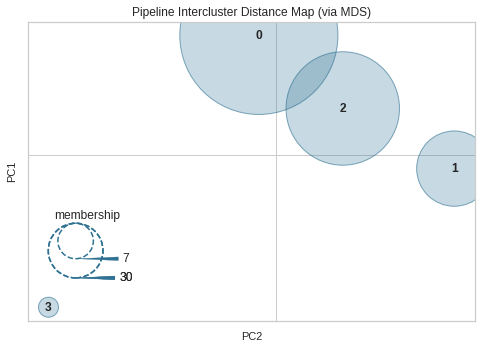

In [ ]:
plot_model(kmeans, plot = 'distance'	) 

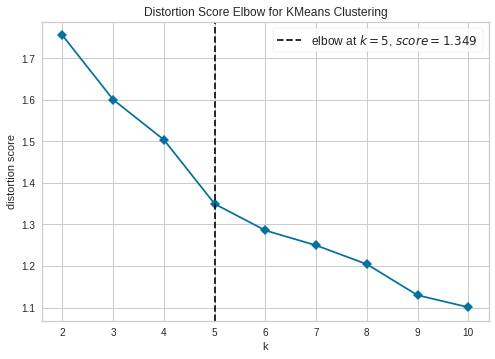

In [ ]:
plot_model(kmeans, plot = 'elbow'	) 

Thus, we can see from the above curves and the table that 10 clusters best serve our purpose. The decrease in sum of squares after 10 is not large enough. Hence, for our analysis, we select 10 clusters.

We now use the Guassian Mixture clustering algorithm to assign the companies to 10 clusters based on their returns. Gaussian Mixture is an uses a probabilistic method of determining the appropriate cluster for a series of observation, assuming the universe is formed out of different Gaussian distributions.

In [ ]:
#Get 7 clusters
gmm = GaussianMixture(n_components = 5)
gmm.fit(transposed.dropna().transpose())

#Predict for each company
clusters = gmm.predict(transposed.dropna().transpose())
clusters_df = pd.DataFrame({'Cluster':clusters,
                           'Companies':transposed.columns})

#Sort by Clusters
clusters_df = clusters_df.sort_values(['Cluster']).reset_index(drop = True)

#Save as csv
clusters_df.to_csv("clusters.csv")
clusters_df = pd.read_csv("clusters.csv", index_col = 0)
clusters_df.head()

,Cluster,Companies
0,0,JNJ
1,0,NFLX
2,0,NEE
3,0,MSFT
4,0,MRK


In [ ]:
!rm -rf '/content/drive/MyDrive/Work/Projects/CRYPTO/clusters.csv'
!cp 'clusters.csv' '/content/drive/MyDrive/Work/Projects/CRYPTO/'

In [ ]:
clusters_df = pd.read_csv("/content/drive/MyDrive/Work/Projects/CRYPTO/clusters.csv", index_col = 0)
for c in clusters_df['Cluster'].unique():
  print(f"Cluster number - {c}")
  print(clusters_df.loc[clusters_df['Cluster']==c,"Companies"])

Cluster number - 0
0      JNJ
1     NFLX
2      NEE
3     MSFT
4      MRK
      ... 
80     ADP
81     ECL
82     DHR
83     ABT
84      FB
Name: Companies, Length: 85, dtype: object
Cluster number - 1
85    MRNA
86    AAPL
87    TSLA
88    ILMN
89     AMD
90    ABNB
91    QCOM
Name: Companies, dtype: object
Cluster number - 2
92      PNC
93     BKNG
94      XOM
95      TFC
96      BAC
97       BA
98     SCCO
99     SCHW
100     USB
101     UNP
102     AXP
103     WFC
104     RTX
105    FISV
106     DIS
107      GE
108     FCX
109      GM
110     GPN
111      GS
112     HCA
113     EMR
114     HON
115      EL
116     BSX
117     JPM
118      DE
119     CVX
120       C
121      MS
122     NSC
123      MA
124     CAT
125     COF
126     MET
127     CME
128     COP
Name: Companies, dtype: object
Cluster number - 3
129     VIAC
130    VIACA
Name: Companies, dtype: object
Cluster number - 4
131     ADI
132    LRCX
133    WDAY
134    PYPL
135     NOW
136    ADBE
137      MU
138    ADSK
139  

###Data Preparation and Spliting

**Training period**

Since our data is a time series data and we want to split the Train-Test as a timeline rather than randomly selecting observations as train or test.
We first convert our index into a date time index and split the data to before and after 31st December 2018.
Train period: 15th October 1990 – 31st December 2018
Test period: 1st January 2019 — Present Working Day

In [ ]:
all_data.index = pd.to_datetime(all_data.index)
all_data = all_data.sort_index()

In [ ]:
#all_data.index = pd.to_datetime(all_data.index)
train_data = all_data.loc[:'2018-12-31',]
test_data = all_data.loc['2019-01-01':] 

In [ ]:
#Separate between X and Y
X_train = train_data.loc[:,Target_variables]
X_train.tail(1)

,SMA_ratio,EMA_ratio,ATR_5,ATR_15,ATR_Ratio,ADX_5,ADX_15,SMA_Volume_Ratio,EMA_Volume_ratio,Stochastic_5,Stochastic_15,Stochastic_Ratio,RSI_5,RSI_15,RSI_ratio,MACD
Date,,,,,,,,,,,,,,,,
2018-12-31,1.01252,1.0,3.101983,3.078092,0.99431,31.467857,17.199879,0.733927,1.0,87.664491,62.495631,1.463322,87.266337,49.262827,1.605192,-1.273608


In [ ]:
Y_train = train_data.loc[:,['Target_Direction']]
Y_train.tail(1)

,Target_Direction
Date,
2018-12-31,1


###Modelling


####Random Forest Model

In [ ]:
#Run the loop for every unique cluster - 17 loops
for cluster_selected in clusters_df.Cluster.unique():
    
    print(f'The current cluster running is : {cluster_selected}')
    
    #Get data for that cluster
    co_data = all_data[all_data.symbol.isin(clusters_df.loc[clusters_df.Cluster==cluster_selected,'Companies'].tolist())].copy()
    co_train = co_data[:'2018-12-31']
    co_train = co_train.dropna().copy()
    
    X_train = co_train.loc[:,Target_variables]

    Y_train = co_train.loc[:,['Target_Direction']]

    #Define paramters from Validation Curve
    params = {'max_depth': [5, 7],
          'max_features': ['sqrt'],
          'min_samples_leaf': [10, 15, 20],
          'n_estimators': [5, 7, 9],
          'min_samples_split':[20, 25, 30]}

    rf = RandomForestClassifier()

    #Perform a TimeSeriesSplit on the dataset
    time_series_split = TimeSeriesSplit(n_splits = 3)

    
    rf_cv = RandomizedSearchCV(rf, params, cv = time_series_split, n_jobs = -1, verbose = 1)

    #Fit the random forest with our X_train and Y_train
    rf_cv.fit(X_train, Y_train)      
    #Save the fited variable into a Pickle file
    file_loc = f'RF_Cluster_{cluster_selected}'
    pickle.dump(rf_cv, open(file_loc,'wb'))

NameError: ignored

In [ ]:
!rm -rf '/content/drive/MyDrive/Work/Projects/CRYPTO/RF_Cluster_0'
!rm -rf '/content/drive/MyDrive/Work/Projects/CRYPTO/RF_Cluster_1'
!rm -rf '/content/drive/MyDrive/Work/Projects/CRYPTO/RF_Cluster_2'
!rm -rf '/content/drive/MyDrive/Work/Projects/CRYPTO/RF_Cluster_3'
!rm -rf '/content/drive/MyDrive/Work/Projects/CRYPTO/RF_Cluster_4'

In [ ]:
!cp '/content/RF_Cluster_0' '/content/drive/MyDrive/Work/Projects/CRYPTO/'
!cp '/content/RF_Cluster_1' '/content/drive/MyDrive/Work/Projects/CRYPTO/'
!cp '/content/RF_Cluster_2' '/content/drive/MyDrive/Work/Projects/CRYPTO/'
!cp '/content/RF_Cluster_3' '/content/drive/MyDrive/Work/Projects/CRYPTO/'
!cp '/content/RF_Cluster_4' '/content/drive/MyDrive/Work/Projects/CRYPTO/'
!cp '/content/RF_Cluster_5' '/content/drive/MyDrive/Work/Projects/CRYPTO/'

cp: cannot stat '/content/RF_Cluster_0': No such file or directory
cp: cannot stat '/content/RF_Cluster_1': No such file or directory
cp: cannot stat '/content/RF_Cluster_2': No such file or directory
cp: cannot stat '/content/RF_Cluster_3': No such file or directory
cp: cannot stat '/content/RF_Cluster_4': No such file or directory
cp: cannot stat '/content/RF_Cluster_5': No such file or directory


In [ ]:
!rm -rf '/content/RF_Cluster_0'
!rm -rf '/content/RF_Cluster_1'
!rm -rf '/content/RF_Cluster_2'
!rm -rf '/content/RF_Cluster_3'
!rm -rf '/content/RF_Cluster_4'
!rm -rf '/content/RF_Cluster_5'

!cp '/content/drive/MyDrive/Work/Projects/CRYPTO/RF_Cluster_0' '/content/'
!cp '/content/drive/MyDrive/Work/Projects/CRYPTO/RF_Cluster_1' '/content/'
!cp '/content/drive/MyDrive/Work/Projects/CRYPTO/RF_Cluster_2' '/content/'
!cp '/content/drive/MyDrive/Work/Projects/CRYPTO/RF_Cluster_3' '/content/'
!cp '/content/drive/MyDrive/Work/Projects/CRYPTO/RF_Cluster_4' '/content/'
!cp '/content/drive/MyDrive/Work/Projects/CRYPTO/RF_Cluster_5' '/content/'

cp: cannot stat '/content/drive/MyDrive/Work/Projects/CRYPTO/RF_Cluster_0': No such file or directory
cp: cannot stat '/content/drive/MyDrive/Work/Projects/CRYPTO/RF_Cluster_1': No such file or directory
cp: cannot stat '/content/drive/MyDrive/Work/Projects/CRYPTO/RF_Cluster_2': No such file or directory
cp: cannot stat '/content/drive/MyDrive/Work/Projects/CRYPTO/RF_Cluster_3': No such file or directory
cp: cannot stat '/content/drive/MyDrive/Work/Projects/CRYPTO/RF_Cluster_4': No such file or directory
cp: cannot stat '/content/drive/MyDrive/Work/Projects/CRYPTO/RF_Cluster_5': No such file or directory


In [ ]:
def get_model_evaluation(date):
  #Use 2nd January Data
  day_data = test_data.loc[date]
  #print(day_data)

  pred_for_tomorrow = pd.DataFrame({'Date':[],
                                    'company':[],
                                    'prediction':[]})

  #Predict each stock using the 2nd January Data
  for cluster_selected in clusters_df.Cluster.unique():
      rf_cv =  pickle.load(open(f'RF_Cluster_{cluster_selected}', 'rb'))
      best_rf = rf_cv.best_estimator_
      cluster_data = day_data.loc[day_data.symbol.isin(clusters_df.loc[clusters_df.Cluster==cluster_selected,'Companies'].tolist())].copy()
      cluster_data = cluster_data.dropna()
      if (cluster_data.shape[0]>0):
          X_test = cluster_data.loc[:,Target_variables]

          pred_for_tomorrow = pred_for_tomorrow.append(pd.DataFrame({'Date':cluster_data.index,
                                                                    'company':cluster_data['symbol'],
                                                                    'prediction':best_rf.predict_proba(X_test)[:,1],
                                                                    'prediction_round':best_rf.predict(X_test)}),
                                                      ignore_index = True)
  #print(pred_for_tomorrow.head())
  top_10_pred = pred_for_tomorrow.sort_values(by = ['prediction'], ascending = False)#.head(30)

  for selected_company in top_10_pred['company']:
      actual = all_data[all_data.symbol == selected_company].loc[date,'Target_Direction']
      pct_change = all_data[all_data.symbol == selected_company].loc[date,'Target']
      top_10_pred.loc[top_10_pred.company == selected_company,'actual'] = actual
      top_10_pred.loc[top_10_pred.company == selected_company,'pct_change'] = pct_change

  print("Accuracy for Random Forest: ",metrics.accuracy_score(top_10_pred['actual'],top_10_pred['prediction_round']))

  print("Confusion Matrix")
  print(metrics.confusion_matrix(top_10_pred['actual'],top_10_pred['prediction_round']))

  print("ROC-AUC")
  print(metrics.roc_auc_score(top_10_pred['actual'], top_10_pred['prediction']))

  # Building ROC curve
  rf_roc_auc = metrics.roc_auc_score(top_10_pred['actual'], top_10_pred['prediction_round'])
  fpr, tpr, thresholds = metrics.roc_curve(top_10_pred['actual'], top_10_pred['prediction'])
  plt.figure()
  plt.plot(fpr, tpr, label='Random Forest (area = %0.3f)' % rf_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate', fontsize=14)
  plt.ylabel('True Positive Rate', fontsize=14)
  plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
  plt.legend(loc="lower right", fontsize=14)
  plt.savefig('RF_ROC', fontsize=14)
  plt.show();

In [ ]:
get_model_evaluation(date='2019-02-04')

NameError: ignored

#Predictions and Analysis

###Predictions

This showcases the final validation output of our Model along with SHAP model explainability. Here we have the predictions for which stock should we buy on `2019-02-04`.

In [ ]:
Target_variables = ['SMA_ratio','EMA_ratio','ATR_5','ATR_15','ATR_Ratio',
                       'ADX_5','ADX_15','SMA_Volume_Ratio','EMA_Volume_ratio','Stochastic_5','Stochastic_15','Stochastic_Ratio',
                      'RSI_5','RSI_15','RSI_ratio','MACD']

In [ ]:
!cp '/content/drive/MyDrive/Work/Projects/CRYPTO/all_data_ti.csv' '/content/'
!rm -rf '/content/RF_Cluster_0'
!rm -rf '/content/RF_Cluster_1'
!rm -rf '/content/RF_Cluster_2'
!rm -rf '/content/RF_Cluster_3'
!rm -rf '/content/RF_Cluster_4'
!rm -rf '/content/RF_Cluster_5'

!cp '/content/drive/MyDrive/Work/Projects/CRYPTO/RF_Cluster_0' '/content/'
!cp '/content/drive/MyDrive/Work/Projects/CRYPTO/RF_Cluster_1' '/content/'
!cp '/content/drive/MyDrive/Work/Projects/CRYPTO/RF_Cluster_2' '/content/'
!cp '/content/drive/MyDrive/Work/Projects/CRYPTO/RF_Cluster_3' '/content/'
!cp '/content/drive/MyDrive/Work/Projects/CRYPTO/RF_Cluster_4' '/content/'
!cp '/content/drive/MyDrive/Work/Projects/CRYPTO/RF_Cluster_5' '/content/'

!cp '/content/drive/MyDrive/Work/Projects/CRYPTO/clusters.csv' '/content/'

In [ ]:
dftx = pd.read_csv("all_data_ti.csv",index_col="Date")
dftx['Close_Shifted'] = dftx.groupby('symbol')['Close'].transform(lambda x: x.shift(-6))
dftx['Target'] = ((dftx['Close_Shifted'] - dftx['Open'])/(dftx['Open']) * 100).shift(-1)
dftx['Target_Direction'] = np.where(dftx['Target']>0,1,0)

In [ ]:
dftx.tail(8)

,High,Low,Open,Close,Volume,Adj Close,symbol,return,SMA_5,SMA_15,SMA_ratio,EMA_5,EMA_15,EMA_ratio,SMA5_Volume,SMA15_Volume,SMA_Volume_Ratio,EMA_5_Volume,EMA_15_Volume,EMA_Volume_ratio,prev_close,TR,ATR_5,ATR_15,ATR_Ratio,prev_high,prev_low,+DM,-DM,+DM_5,-DM_5,+DM_15,-DM_15,+DI_5,-DI_5,+DI_15,-DI_15,DX_5,DX_15,ADX_5,ADX_15,Lowest_5D,High_5D,Lowest_15D,High_15D,Stochastic_5,Stochastic_15,Stochastic_%D_5,Stochastic_%D_15,Stochastic_Ratio,Diff,Up,Down,avg_5up,avg_5down,avg_15up,avg_15down,RS_5,RS_15,RSI_5,RSI_15,RSI_ratio,5Ewm,15Ewm,MACD,15MA,SD,upperband,lowerband,RC,Close_Shifted,Target,Target_Direction
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-15,75.559998,72.919998,75.139999,74.930000,3717700.0,74.930000,BX,0.001203,72.778000,70.106667,0.963295,73.053493,73.053493,1.0,3778740.0,3.402307e+06,1.110641,3.821809e+06,3.821809e+06,1.0,74.839996,2.639999,2.600467,2.100825,1.237832,75.269997,73.050003,0.290001,0.000000,0.931828,0.316932,0.602426,0.387816,35.833103,12.187521,28.675682,18.460177,49.0,22.0,36.352028,22.536914,67.800003,75.559998,63.709999,75.559998,91.881473,94.683567,91.671472,64.515444,1.420923,0.090004,0.090004,0.000000,1.480000,0.000000,0.786000,0.425333,inf,1.847963,100.000000,64.887188,1.541136,73.053493,70.874565,-2.178929,70.106667,2.665131,75.436929,64.776405,0.077819,73.190002,-4.166673,0
2021-03-16,76.250000,74.029999,75.120003,74.870003,4418000.0,74.870003,BX,-0.000801,73.882001,70.478000,0.953927,73.658996,73.658996,1.0,3866000.0,3.540213e+06,1.092025,4.020539e+06,4.020539e+06,1.0,74.930000,2.220001,2.524374,2.108770,1.197084,75.559998,72.919998,0.690002,0.000000,0.883463,0.253546,0.608264,0.361962,34.997309,10.043916,28.844507,17.164584,55.0,25.0,40.081623,22.701120,69.779999,76.250000,63.709999,76.250000,78.670835,88.995238,91.889831,66.342792,1.385076,-0.059998,0.000000,0.059998,1.116000,0.012000,0.786000,0.414667,93.003815,1.895498,98.936213,65.463629,1.511316,73.658996,71.373994,-2.285002,70.478000,2.920510,76.319019,64.636981,0.080375,71.989998,NaN,0
2021-03-17,76.099998,73.910004,74.699997,76.089996,2877100.0,76.089996,BX,0.016295,74.948000,70.893333,0.945900,74.469330,74.469330,1.0,3816660.0,3.599487e+06,1.060335,3.639393e+06,3.639393e+06,1.0,74.870003,2.189995,2.457498,2.114185,1.162386,76.250000,74.029999,0.000000,0.119995,0.706770,0.226836,0.567713,0.345830,28.759752,9.230356,26.852587,16.357627,51.0,24.0,42.265298,22.787712,70.900002,76.250000,63.709999,76.250000,97.009276,98.724054,92.134071,67.341566,1.368161,1.219994,1.219994,0.000000,1.077998,0.012000,0.830000,0.414667,89.836851,2.001607,98.899125,66.684511,1.483090,74.469330,71.963495,-2.505835,70.893333,3.250674,77.394681,64.391986,0.089178,NaN,NaN,0
2021-03-18,75.989998,72.900002,75.879997,73.029999,2533500.0,73.029999,BX,-0.040216,74.751999,71.201333,0.952501,73.989553,73.989553,1.0,3398140.0,3.621980e+06,0.938200,3.270762e+06,3.270762e+06,1.0,76.089996,3.189995,2.603997,2.185905,1.191267,76.099998,73.910004,0.000000,1.010002,0.565416,0.383469,0.529866,0.390109,21.713396,14.726169,24.240104,17.846544,19.0,15.0,37.612239,22.268531,72.900002,76.250000,63.709999,76.250000,3.880517,74.322161,73.384108,66.586436,1.102088,-3.059998,0.000000,3.059998,0.427998,0.623999,0.830000,0.522000,0.685896,1.590038,40.684355,61.390521,0.662714,73.989553,72.096808,-1.892745,71.201333,3.217272,77.635878,64.766789,0.067534,NaN,NaN,0
2021-03-19,72.849998,71.339996,71.849998,72.470001,2712800.0,72.470001,BX,-0.007668,74.278000,71.417333,0.961487,73.483036,73.483036,1.0,3251820.0,3.574853e+06,0.909637,3.084775e+06,3.084775e+06,1.0,73.029999,1.690002,2.421198,2.152845,1.124651,75.989998,72.900002,0.000000,1.560005,0.452333,0.618776,0.494541,0.468102,18.682195,25.556612,22.971524,21.743397,16.0,3.0,33.289791,20.983962,71.339996,76.250000,63.709999,76.250000,23.014339,69.856471,58.891288,64.370715,0.914877,-0.559998,0.000000,0.559998,0.262000,0.735999,0.775333,0.559333,0.355978,1.386174,26.252507,58.091904,0.451913,73.4830

In [ ]:
clusters_df = pd.read_csv("clusters.csv", index_col = 0)
def get_pridiction(date):
  #Use 2nd January Data
  day_data = dftx.loc[date]
  #print(day_data)

  pred_for_tomorrow = pd.DataFrame({'Date':[],
                                    'company':[],
                                    'prediction':[]})

  #Predict each stock using the 2nd January Data
  for cluster_selected in clusters_df.Cluster.unique():
      rf_cv =  pickle.load(open(f'RF_Cluster_{cluster_selected}', 'rb'))
      best_rf = rf_cv.best_estimator_
      cluster_data = day_data.loc[day_data.symbol.isin(clusters_df.loc[clusters_df.Cluster==cluster_selected,'Companies'].tolist())].copy()
      cluster_data = cluster_data.dropna()
      if (cluster_data.shape[0]>0):
          X_test = cluster_data.loc[:,Target_variables]

          pred_for_tomorrow = pred_for_tomorrow.append(pd.DataFrame({'Date':cluster_data.index,
                                                                    'company':cluster_data['symbol'],
                                                                    'prediction':best_rf.predict_proba(X_test)[:,1],
                                                                    'prediction_round':best_rf.predict(X_test)}),
                                                      ignore_index = True)
  #print(pred_for_tomorrow.head())
  top_10_pred = pred_for_tomorrow.sort_values(by = ['prediction'], ascending = False)#.head(30)

  for selected_company in top_10_pred['company']:
      actual = dftx[dftx.symbol == selected_company].loc[date,'Target_Direction']
      pct_change = dftx[dftx.symbol == selected_company].loc[date,'Target']
      top_10_pred.loc[top_10_pred.company == selected_company,'actual'] = actual
      top_10_pred.loc[top_10_pred.company == selected_company,'pct_change'] = pct_change

  return top_10_pred.head(10)

def get_force_shap(company,date):
  shap_df = dftx.loc[date]
  shap_df = shap_df[shap_df['symbol']==company]
  shap_df = shap_df.loc[:,Target_variables]
  #print(shap_df)
  cluster_number = clusters_df[clusters_df['Companies']==company].iat[0,0]
  #print(cluster_number)
  rf_shap =  pickle.load(open(f'RF_Cluster_{cluster_number}', 'rb'))
  best_rf = rf_shap.best_estimator_
  explainer = shap.TreeExplainer(best_rf)
  choosen_instance = shap_df
  shap_values = explainer.shap_values(choosen_instance)
  shap.initjs()
  return shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)
  
def make_shap_waterfall_plot(shap_values, features, num_display=20):
    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]
    
    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4
        
    fig, ax1 = plt.subplots(figsize=(8, 8 + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='blue', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6)
    
    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=13)
    plt.ylim(-1, len(column_list))
    
def get_waterfall_shap(company):
  samples = dftx[dftx['symbol']==company].loc[:,Target_variables]
  cluster_number = clusters_df[clusters_df['Companies']==company].iat[0,0]
  rf_shap =  pickle.load(open(f'RF_Cluster_{cluster_number}', 'rb'))
  best_rf = rf_shap.best_estimator_
  explainer = shap.TreeExplainer(best_rf)
  shap_values = explainer.shap_values(samples, approximate=False, check_additivity=False)
  # Shap waterfall plot
  return make_shap_waterfall_plot(shap_values[1], samples)

def get_dependence_shap(features, company):
  samples = dftx[dftx['symbol']==company].loc[:,Target_variables]
  cluster_number = clusters_df[clusters_df['Companies']==company].iat[0,0]
  rf_shap =  pickle.load(open(f'RF_Cluster_{cluster_number}', 'rb'))
  best_rf = rf_shap.best_estimator_
  explainer = shap.TreeExplainer(best_rf)
  shap_values = explainer.shap_values(samples, approximate=False, check_additivity=False)
  # Visualizing top features
  for feature in top_features:
    shap.dependence_plot(feature, shap_values[1], samples, interaction_index=None)

def get_summary_shap(company):
  samples = dftx[dftx['symbol']==company].loc[:,Target_variables]
  cluster_number = clusters_df[clusters_df['Companies']==company].iat[0,0]
  rf_shap =  pickle.load(open(f'RF_Cluster_{cluster_number}', 'rb'))
  best_rf = rf_shap.best_estimator_
  explainer = shap.TreeExplainer(best_rf)
  shap_values = explainer.shap_values(samples, approximate=False, check_additivity=False)
  return shap.summary_plot(shap_values[1], samples)

In the given dataframe, we have the probabiltiy prediction sorted on decreasing order whether we should buy the stock, rounded predictions, actual predictions and percentage change. 

You can see that we get 7/10 predictions correctly.

In [ ]:
get_pridiction(date='2021-01-15')

,Date,company,prediction,prediction_round,actual,pct_change
93,2021-01-15,DIS,0.616232,1.0,0.0,-5.270196
20,2021-01-15,CRM,0.593029,1.0,1.0,4.378915
14,2021-01-15,KO,0.591517,1.0,0.0,-0.430864
88,2021-01-15,AMD,0.574855,1.0,0.0,-0.803932
43,2021-01-15,MMM,0.573475,1.0,1.0,11.592730
15,2021-01-15,NKE,0.573473,1.0,0.0,-7.071424
22,2021-01-15,ORCL,0.573362,1.0,1.0,0.724639
70,2021-01-15,ICE,0.572133,1.0,0.0,-5.275471
30,2021-01-15,MDT,0.567974,1.0,0.0,-5.227371
140,2021-01-15,MU,0.566190,1.0,0.0,-7.615653


####SHAP Plots

**SHAP (SHapley Additive exPlanations)** is a method to explain individual predictions. The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional game theory. 

Let me describe this **force_shap** plot in detail:

* The output value is the prediction for that observation (the prediction of the model for a given company on the given date (here it is 0.56).

* The base value :The base value is “the value that would be predicted if we did not know any features for the current output.” 

* Red/blue : Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.

* MACD: has a positive impact on the prediction rating. 

* SMA_Volume_Ratio: is negatively related to the prediction rating.

In [ ]:
get_force_shap(company="GOOGL",date ='2021-03-15')

Based on the **SHAP summary plot**, we can see the top 14 features and their indications of the relationship between the value of a feature and the impact on the classification model.

This plot is made of all the dots in the train data. It demonstrates the following information:

Feature importance: Variables are ranked in descending order.

Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction .

Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.

Correlation: A high level of the ADX_% content has a low and negative impact on the prediction rating. The “low” comes from the blue color, and the “negative” impact is shown on the X-axis. Similarly, we will say the “RSI_15” is positively correlated with the target variable.

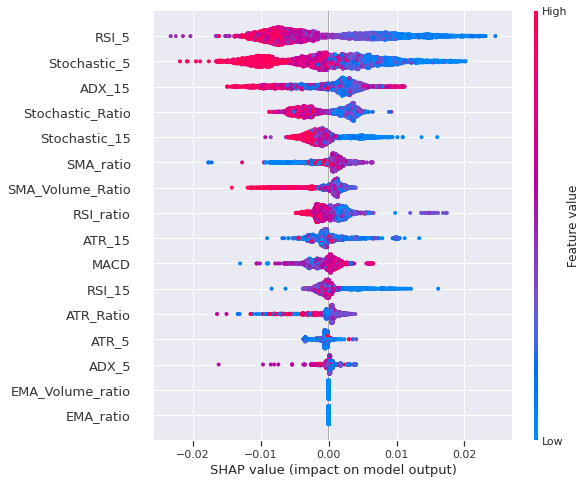

In [ ]:
get_summary_shap(company="GOOGL")

Based on the **SHAP waterfall plot**, we can say that `Stochastic_5`, `Stochastic_Ratio`, `Stochastic_15`  is the most important feature in the model, which has more than 70% of the model’s explainability.

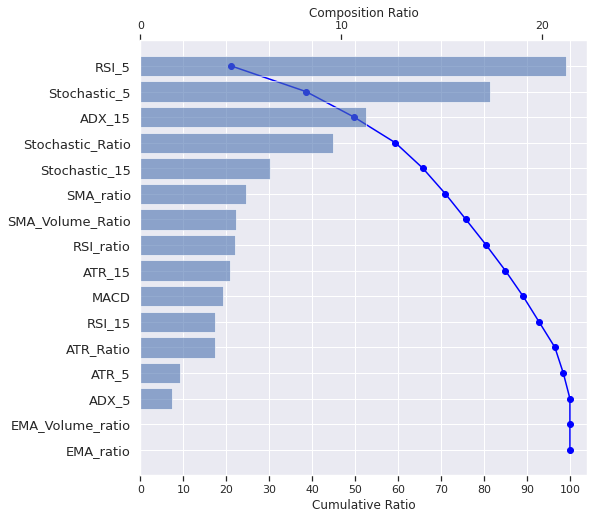

In [ ]:
get_waterfall_shap(company="GOOGL")

The partial dependence plot shows the marginal effect one or two features have on the predicted outcome of a machine learning model. It tells whether the relationship between the target and a feature is linear, monotonic or more complex

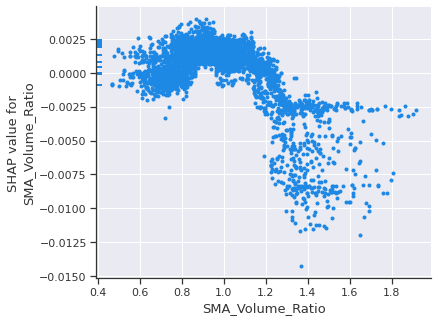

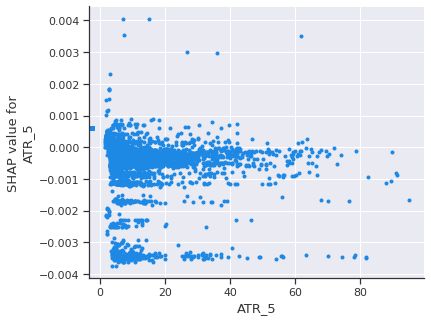

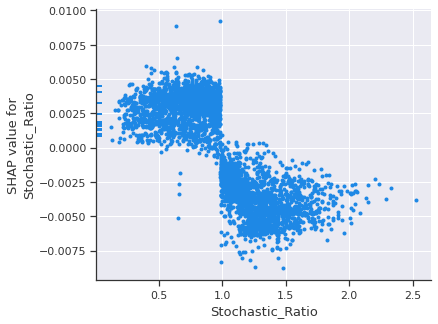

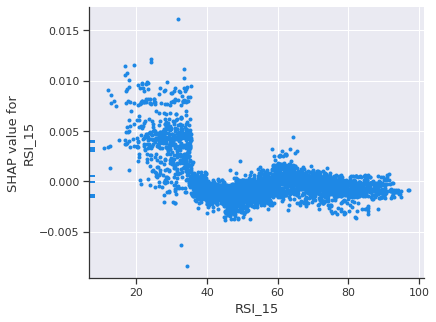

In [ ]:
# Let's have a look on the top features and their dependence plots
top_features = ['SMA_Volume_Ratio', 'ATR_5', 'Stochastic_Ratio', 'RSI_15']
get_dependence_shap(features=top_features, company="GOOGL")

###Testing

Check the last date of available data. Taking dates after the given below date or of any Saturday and Sunday for result in a error.


In [ ]:
dft = pd.read_csv("all_data_ti.csv",index_col="Date")

def get_future_predictions(date):
  day_data = dft.loc[date]
  #print(day_data)

  pred_for_tomorrow = pd.DataFrame({'Date':[],
                                    'company':[],
                                    'prediction':[]})

  #Predict each stock using the 2nd January Data
  for cluster_selected in clusters_df.Cluster.unique():
      rf_cv =  pickle.load(open(f'RF_Cluster_{cluster_selected}', 'rb'))
      best_rf = rf_cv.best_estimator_
      cluster_data = day_data.loc[day_data.symbol.isin(clusters_df.loc[clusters_df.Cluster==cluster_selected,'Companies'].tolist())].copy()
      cluster_data = cluster_data.dropna()
      if (cluster_data.shape[0]>0):
          X_test = cluster_data.loc[:,Target_variables]

          pred_for_tomorrow = pred_for_tomorrow.append(pd.DataFrame({'Date':cluster_data.index,
                                                                    'company':cluster_data['symbol'],
                                                                    'prediction':best_rf.predict_proba(X_test)[:,1],
                                                                    'prediction_round':best_rf.predict(X_test)}),
                                                      ignore_index = True)
  #print(pred_for_tomorrow.head())
  top_10_pred = pred_for_tomorrow.sort_values(by = ['prediction'], ascending = False).head(10)
  return top_10_pred

def get_force_shap(company,date):
  shap_df = dft.loc[date]
  shap_df = shap_df[shap_df['symbol']==company]
  shap_df = shap_df.loc[:,Target_variables]
  #print(shap_df)
  cluster_number = clusters_df[clusters_df['Companies']==company].iat[0,0]
  print(cluster_number)
  rf_shap =  pickle.load(open(f'RF_Cluster_{cluster_number}', 'rb'))
  best_rf = rf_shap.best_estimator_
  explainer = shap.TreeExplainer(best_rf)
  choosen_instance = shap_df
  shap_values = explainer.shap_values(choosen_instance)
  shap.initjs()
  return shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

These are predictions for the next week from the curent latest date.

In [ ]:
get_future_predictions(date='2021-03-25')

,Date,company,prediction,prediction_round
86,2021-03-25,TSLA,0.624461,1.0
133,2021-03-25,INTC,0.596035,1.0
85,2021-03-25,AAPL,0.595975,1.0
140,2021-03-25,SQ,0.595321,1.0
132,2021-03-25,PYPL,0.595321,1.0
137,2021-03-25,SE,0.590266,1.0
141,2021-03-25,MU,0.586692,1.0
146,2021-03-25,WDAY,0.583657,1.0
144,2021-03-25,SNAP,0.579800,1.0
88,2021-03-25,ABNB,0.574623,1.0


In [ ]:
get_force_shap(company="TSLA", date = '2021-03-25')

1
